<a href="https://colab.research.google.com/github/tirtharajdash/BITS-G513_MetaLearning/blob/main/Labs/Labs/Lab_4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was adapted from [Udacity's PyTorch Course](https://github.com/udacity/deep-learning-v2-pytorch).

Resources:
 - [CS 231n - CNNs](https://cs231n.github.io/convolutional-networks/)
 - [Cs 231n - Transfer Learning](https://cs231n.github.io/transfer-learning/)
 - [PyTorch Tutorial on Finetuning Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#run-training-and-validation-step)
 - [Lilian Weng's blog on CNN Architectures](https://lilianweng.github.io/lil-log/2017/12/15/object-recognition-for-dummies-part-2.html)
 - [Another blog on ANN architectures](https://iq.opengenus.org/evolution-of-cnn-architectures/)
 - [ImageNet Benchmarks](https://paperswithcode.com/sota/image-classification-on-imagenet)

# Downloading the data onto Colab

In [ ]:
! curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1G2LnFid9P5RABhQLWnnp83c_mI04SCBr" > /dev/null
! curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1G2LnFid9P5RABhQLWnnp83c_mI04SCBr" -o "out.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3187      0 --:--:-- --:--:-- --:--:--  3162
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  219M    0  219M    0     0  74.3M      0 --:--:--  0:00:02 --:--:-- 98.6M


In [ ]:
! unzip out.zip > /dev/null

# [ 1 ] Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<!-- <img src="notebook_ims/vgg_16_architecture.png" width=700px> -->
![vgg_16_architecture.png](attachment:vgg_16_architecture.png)

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

Download the flower data from [this link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), save it in the home directory of this notebook and extract the zip file to get the directory `flower_photos/`. **Make sure the directory has this exact name for accessing data: flower_photos**.

In [ ]:
import os
import numpy as np
import torch

import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# [2] The Dataset

## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [ ]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [ ]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [ ]:
# define dataloader parameters
batch_size = 20
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

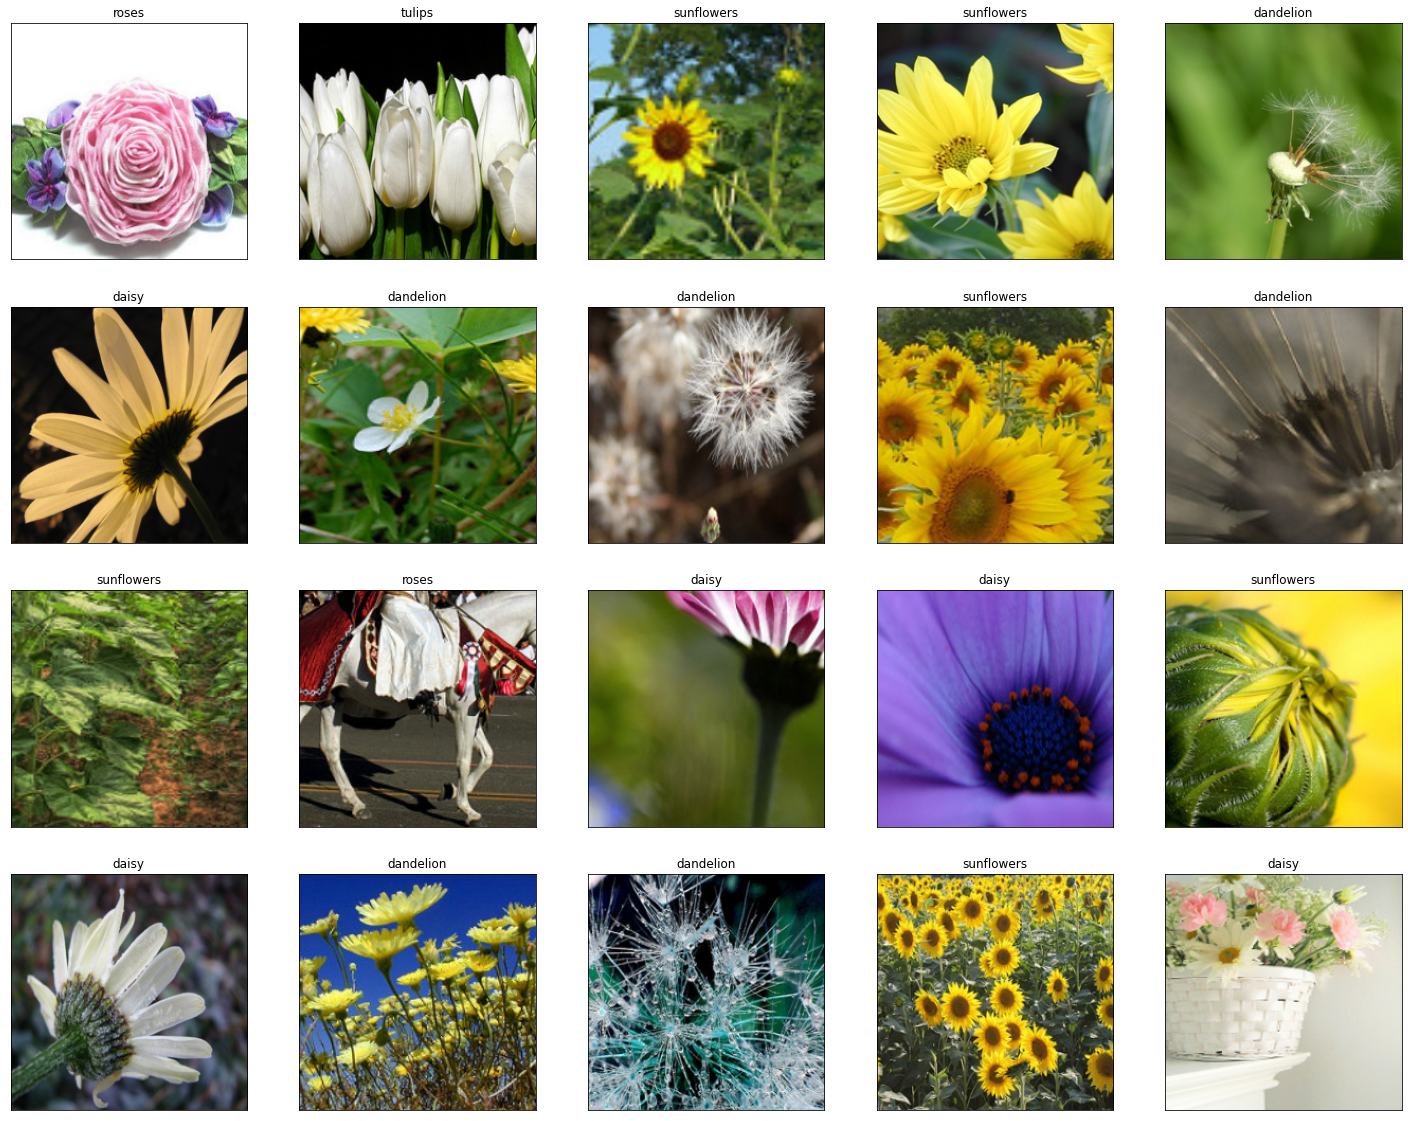

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 20))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# [3] Fine-Tuning a Pre-Trained model

## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [ ]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

---
### Final Classifier Layer


In [ ]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


# [4] Define Training / Testing Functions

In [ ]:
def train_model(model, cfg):
    criterion = nn.CrossEntropyLoss()
    loss_list = []
    
    for epoch in range(1, cfg['n_epochs']+1):
        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss += loss.item()
            
            if (batch_i+1) % 10 == 0:    # print training loss every specified number of mini-batches
                print('[Epoch: {:1d}  Batch: {:3d}]  loss: {:.5f}'.format(epoch, batch_i + 1, train_loss / 10))
                loss_list += [train_loss / 10]
                train_loss = 0.0
                
    return loss_list

In [ ]:
def test_model(model):
    # track test loss 
    # over 5 flower classes
    test_loss = 0.0
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))

    model.eval() # eval mode

    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(5):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
def plot_loss(loss_list, title, figsize=[18,4]):
    plt.figure(figsize=figsize)
    plt.plot(loss_list, '-s')
    plt.title(title)
    plt.grid()
    plt.show()

In [ ]:
def visualize_results(model, num_samples, num_rows, figsize):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=figsize)
    for idx in np.arange(num_samples):
        ax = fig.add_subplot(num_rows, num_samples//num_rows, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                     color=("green" if preds[idx]==labels[idx].item() else "red"))

# [ 5 ] Comparing Different Routines 

In [ ]:
loss_dict = {}
criterion = nn.CrossEntropyLoss()

## VGG Finetune 1

- PreTrained Model
- Freeze Features Module
- FineTune Classifier Module

[Epoch: 1  Batch:  10]  loss: 0.85255
[Epoch: 1  Batch:  20]  loss: 0.78929
[Epoch: 1  Batch:  30]  loss: 0.70216
[Epoch: 1  Batch:  40]  loss: 0.68176
[Epoch: 1  Batch:  50]  loss: 0.64242
[Epoch: 1  Batch:  60]  loss: 0.62461
[Epoch: 1  Batch:  70]  loss: 0.55893
[Epoch: 1  Batch:  80]  loss: 0.53565
[Epoch: 1  Batch:  90]  loss: 0.55178
[Epoch: 1  Batch: 100]  loss: 0.50299
[Epoch: 1  Batch: 110]  loss: 0.49880
[Epoch: 1  Batch: 120]  loss: 0.51091
[Epoch: 1  Batch: 130]  loss: 0.47813
[Epoch: 1  Batch: 140]  loss: 0.48514
[Epoch: 1  Batch: 150]  loss: 0.45266
[Epoch: 2  Batch:  10]  loss: 0.45855
[Epoch: 2  Batch:  20]  loss: 0.45141
[Epoch: 2  Batch:  30]  loss: 0.40308
[Epoch: 2  Batch:  40]  loss: 0.45076
[Epoch: 2  Batch:  50]  loss: 0.39853
[Epoch: 2  Batch:  60]  loss: 0.37746
[Epoch: 2  Batch:  70]  loss: 0.44447
[Epoch: 2  Batch:  80]  loss: 0.35085
[Epoch: 2  Batch:  90]  loss: 0.40088
[Epoch: 2  Batch: 100]  loss: 0.36661
[Epoch: 2  Batch: 110]  loss: 0.37356
[Epoch: 2  B

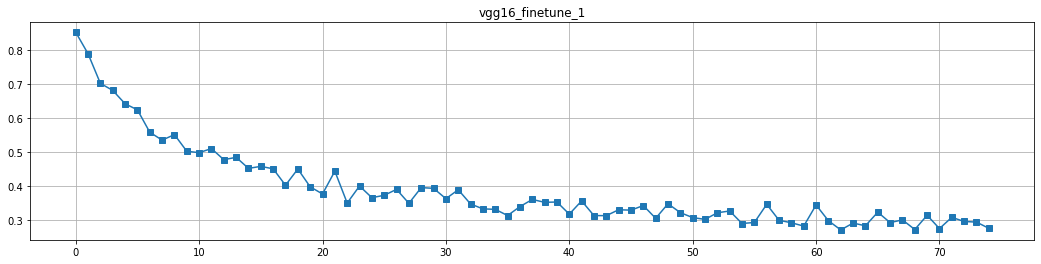

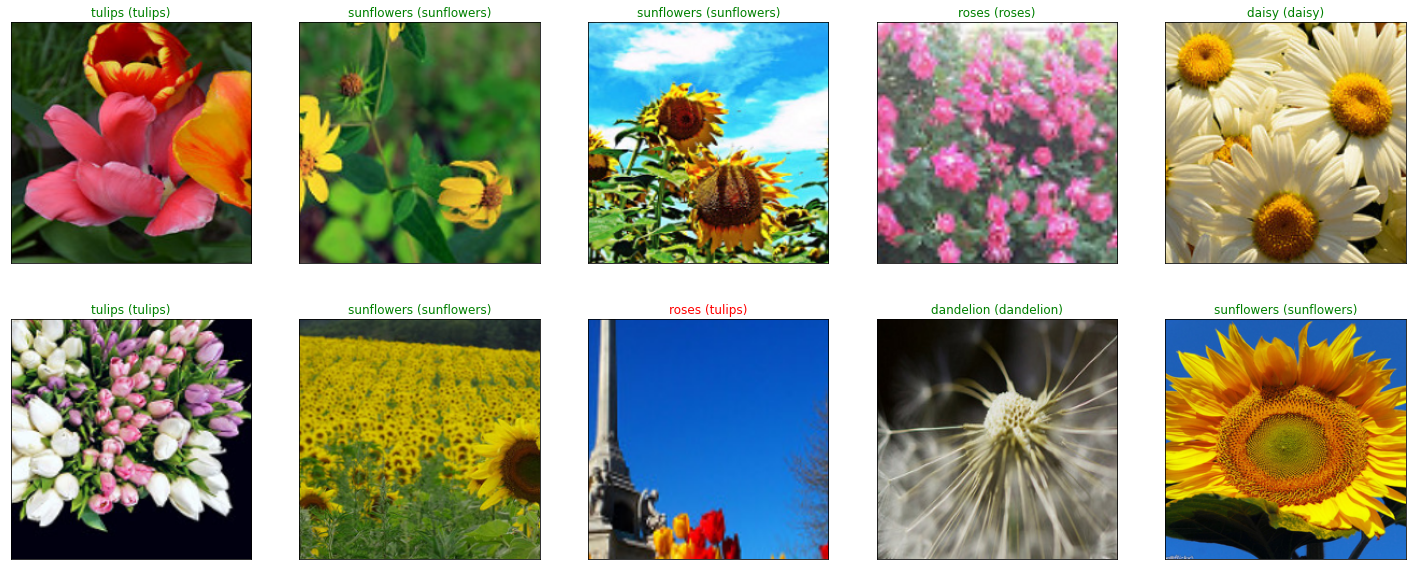

In [ ]:
cfg = {
    'model_name': 'vgg16_finetune_1',
    'n_epochs' : 5,
    'learning_rate': 0.001,
}

# Define Model
vgg16_finetune_1 = models.vgg16(pretrained=True)
for param in vgg16_finetune_1.features.parameters():
    param.requires_grad = False
    
vgg16_finetune_1.classifier[6] = nn.Linear(vgg16_finetune_1.classifier[6].in_features, len(classes))
if train_on_gpu:
    vgg16_finetune_1.cuda()

# Train
optimizer = optim.SGD(vgg16_finetune_1.classifier.parameters(), lr=cfg['learning_rate'])
loss_list_1 = train_model(vgg16_finetune_1, cfg)
loss_dict[cfg['model_name']] = loss_list_1

# Evaluate
test_model(vgg16_finetune_1)
plot_loss(loss_dict[cfg['model_name']], title=cfg['model_name'])
visualize_results(vgg16_finetune_1, 10, 2, [25,10])

## VGG Finetune 2

- PreTrained Model
- FineTune Features + Classifier modules

[Epoch: 1  Batch:  10]  loss: 0.81168
[Epoch: 1  Batch:  20]  loss: 0.72328
[Epoch: 1  Batch:  30]  loss: 0.69359
[Epoch: 1  Batch:  40]  loss: 0.62619
[Epoch: 1  Batch:  50]  loss: 0.56905
[Epoch: 1  Batch:  60]  loss: 0.55890
[Epoch: 1  Batch:  70]  loss: 0.47190
[Epoch: 1  Batch:  80]  loss: 0.50565
[Epoch: 1  Batch:  90]  loss: 0.42905
[Epoch: 1  Batch: 100]  loss: 0.41369
[Epoch: 1  Batch: 110]  loss: 0.40646
[Epoch: 1  Batch: 120]  loss: 0.34475
[Epoch: 1  Batch: 130]  loss: 0.34370
[Epoch: 1  Batch: 140]  loss: 0.34180
[Epoch: 1  Batch: 150]  loss: 0.34886
[Epoch: 2  Batch:  10]  loss: 0.33322
[Epoch: 2  Batch:  20]  loss: 0.31195
[Epoch: 2  Batch:  30]  loss: 0.36245
[Epoch: 2  Batch:  40]  loss: 0.30112
[Epoch: 2  Batch:  50]  loss: 0.29848
[Epoch: 2  Batch:  60]  loss: 0.26741
[Epoch: 2  Batch:  70]  loss: 0.24558
[Epoch: 2  Batch:  80]  loss: 0.26926
[Epoch: 2  Batch:  90]  loss: 0.31016
[Epoch: 2  Batch: 100]  loss: 0.27882
[Epoch: 2  Batch: 110]  loss: 0.27268
[Epoch: 2  B

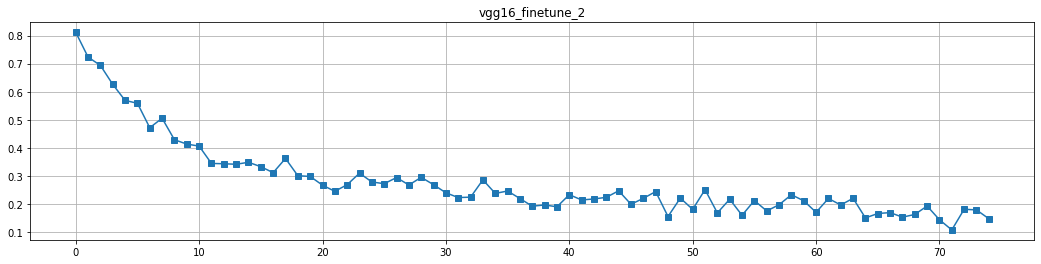

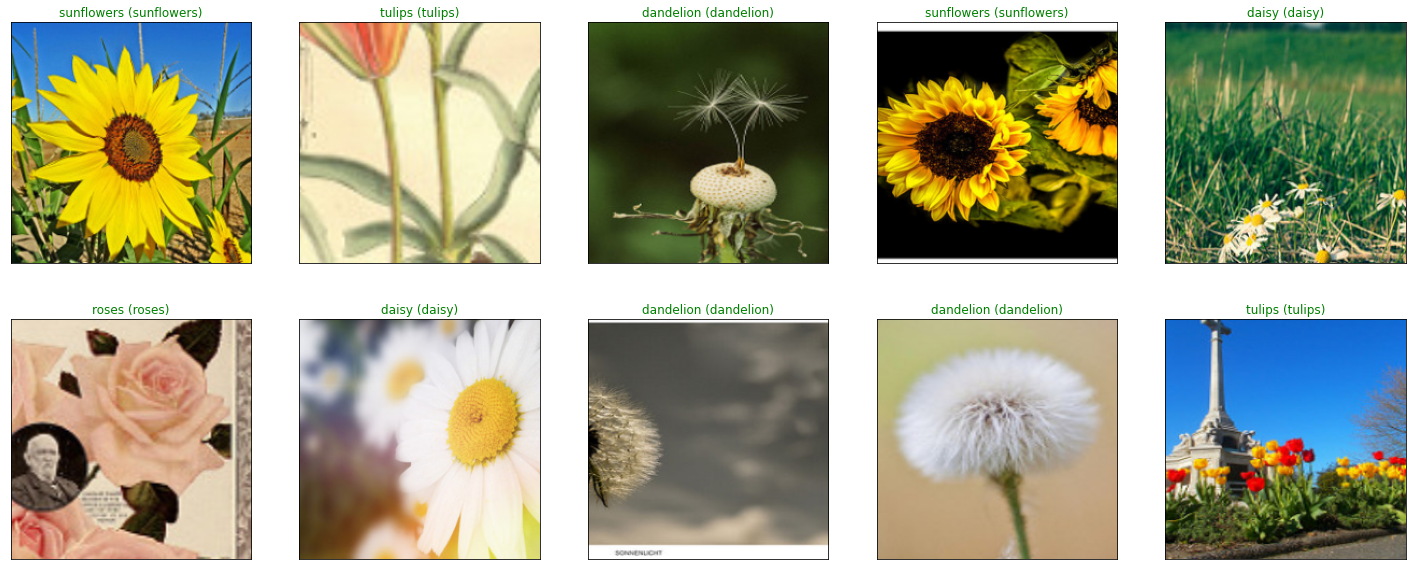

In [ ]:
cfg = {
    'model_name': 'vgg16_finetune_2',
    'n_epochs' : 5,
    'learning_rate': 0.001,
}

# Define Model
vgg16_finetune_2 = models.vgg16(pretrained=True)
    
vgg16_finetune_2.classifier[6] = nn.Linear(vgg16_finetune_2.classifier[6].in_features, len(classes))
if train_on_gpu:
    vgg16_finetune_2.cuda()

# Train
optimizer = optim.SGD(vgg16_finetune_2.parameters(), lr=cfg['learning_rate'])
loss_list_2 = train_model(vgg16_finetune_2, cfg)
loss_dict[cfg['model_name']] = loss_list_2

# Evaluate
test_model(vgg16_finetune_2)
plot_loss(loss_dict[cfg['model_name']], title=cfg['model_name'])
visualize_results(vgg16_finetune_2, 10, 2, [25,10])

## VGG Scratch 

[Epoch: 1  Batch:  10]  loss: 0.80409
[Epoch: 1  Batch:  20]  loss: 0.80664
[Epoch: 1  Batch:  30]  loss: 0.80453
[Epoch: 1  Batch:  40]  loss: 0.80601
[Epoch: 1  Batch:  50]  loss: 0.80305
[Epoch: 1  Batch:  60]  loss: 0.80160
[Epoch: 1  Batch:  70]  loss: 0.80067
[Epoch: 1  Batch:  80]  loss: 0.80576
[Epoch: 1  Batch:  90]  loss: 0.80069
[Epoch: 1  Batch: 100]  loss: 0.80362
[Epoch: 1  Batch: 110]  loss: 0.80641
[Epoch: 1  Batch: 120]  loss: 0.80591
[Epoch: 1  Batch: 130]  loss: 0.80271
[Epoch: 1  Batch: 140]  loss: 0.80106
[Epoch: 1  Batch: 150]  loss: 0.80211
[Epoch: 2  Batch:  10]  loss: 0.80005
[Epoch: 2  Batch:  20]  loss: 0.80037
[Epoch: 2  Batch:  30]  loss: 0.80260
[Epoch: 2  Batch:  40]  loss: 0.79944
[Epoch: 2  Batch:  50]  loss: 0.80257
[Epoch: 2  Batch:  60]  loss: 0.80107
[Epoch: 2  Batch:  70]  loss: 0.80676
[Epoch: 2  Batch:  80]  loss: 0.79974
[Epoch: 2  Batch:  90]  loss: 0.79858
[Epoch: 2  Batch: 100]  loss: 0.80333
[Epoch: 2  Batch: 110]  loss: 0.79669
[Epoch: 2  B

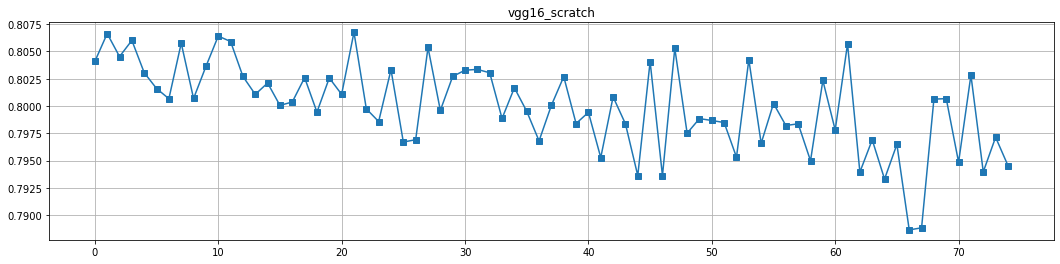

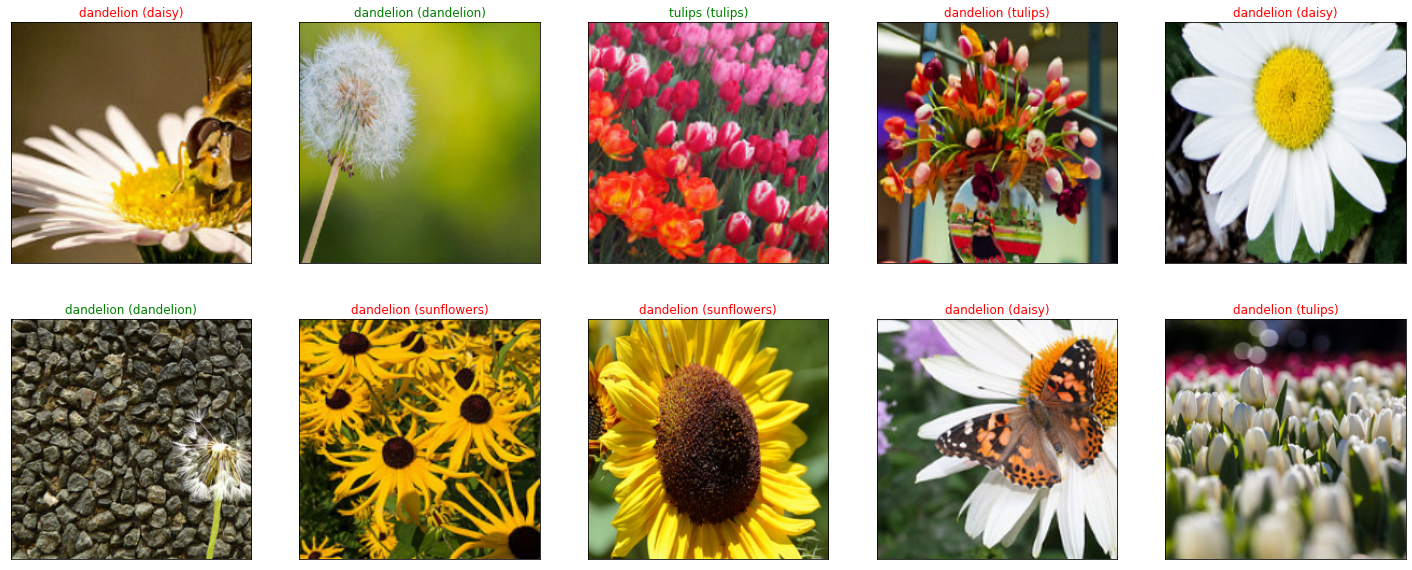

In [ ]:
cfg = {
    'model_name': 'vgg16_scratch',
    'n_epochs' : 5,
    'learning_rate': 0.001,
}

# Define Model
vgg16_scratch = models.vgg16(pretrained=False)
    
vgg16_scratch.classifier[6] = nn.Linear(vgg16_scratch.classifier[6].in_features, len(classes))
if train_on_gpu:
    vgg16_scratch.cuda()

# Train
optimizer = optim.SGD(vgg16_scratch.parameters(), lr=cfg['learning_rate'])
loss_list_3 = train_model(vgg16_scratch, cfg)
loss_dict[cfg['model_name']] = loss_list_3

# Evaluate
test_model(vgg16_scratch)
plot_loss(loss_dict[cfg['model_name']], title=cfg['model_name'])
visualize_results(vgg16_scratch, 10, 2, [25,10])

## VGG Naive 

[Epoch: 1  Batch:  10]  loss: 0.80531
[Epoch: 1  Batch:  20]  loss: 0.80490
[Epoch: 1  Batch:  30]  loss: 0.80545
[Epoch: 1  Batch:  40]  loss: 0.80516
[Epoch: 1  Batch:  50]  loss: 0.80544
[Epoch: 1  Batch:  60]  loss: 0.80424
[Epoch: 1  Batch:  70]  loss: 0.80535
[Epoch: 1  Batch:  80]  loss: 0.80770
[Epoch: 1  Batch:  90]  loss: 0.80516
[Epoch: 1  Batch: 100]  loss: 0.80504
[Epoch: 1  Batch: 110]  loss: 0.80385
[Epoch: 1  Batch: 120]  loss: 0.80529
[Epoch: 1  Batch: 130]  loss: 0.80598
[Epoch: 1  Batch: 140]  loss: 0.80517
[Epoch: 1  Batch: 150]  loss: 0.80452
[Epoch: 2  Batch:  10]  loss: 0.80355
[Epoch: 2  Batch:  20]  loss: 0.80522
[Epoch: 2  Batch:  30]  loss: 0.80305
[Epoch: 2  Batch:  40]  loss: 0.80425
[Epoch: 2  Batch:  50]  loss: 0.80344
[Epoch: 2  Batch:  60]  loss: 0.80447
[Epoch: 2  Batch:  70]  loss: 0.80410
[Epoch: 2  Batch:  80]  loss: 0.80510
[Epoch: 2  Batch:  90]  loss: 0.80530
[Epoch: 2  Batch: 100]  loss: 0.80481
[Epoch: 2  Batch: 110]  loss: 0.80455
[Epoch: 2  B

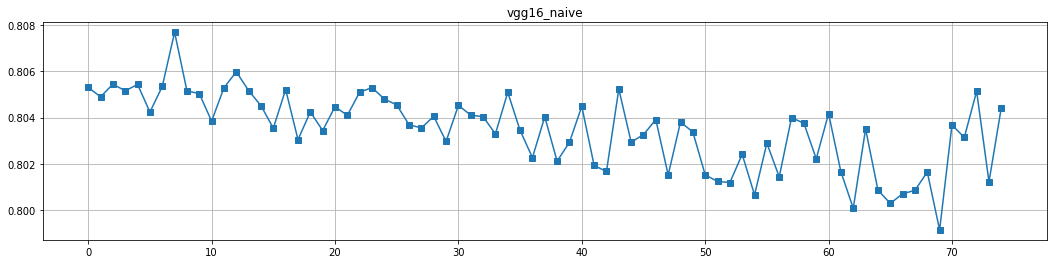

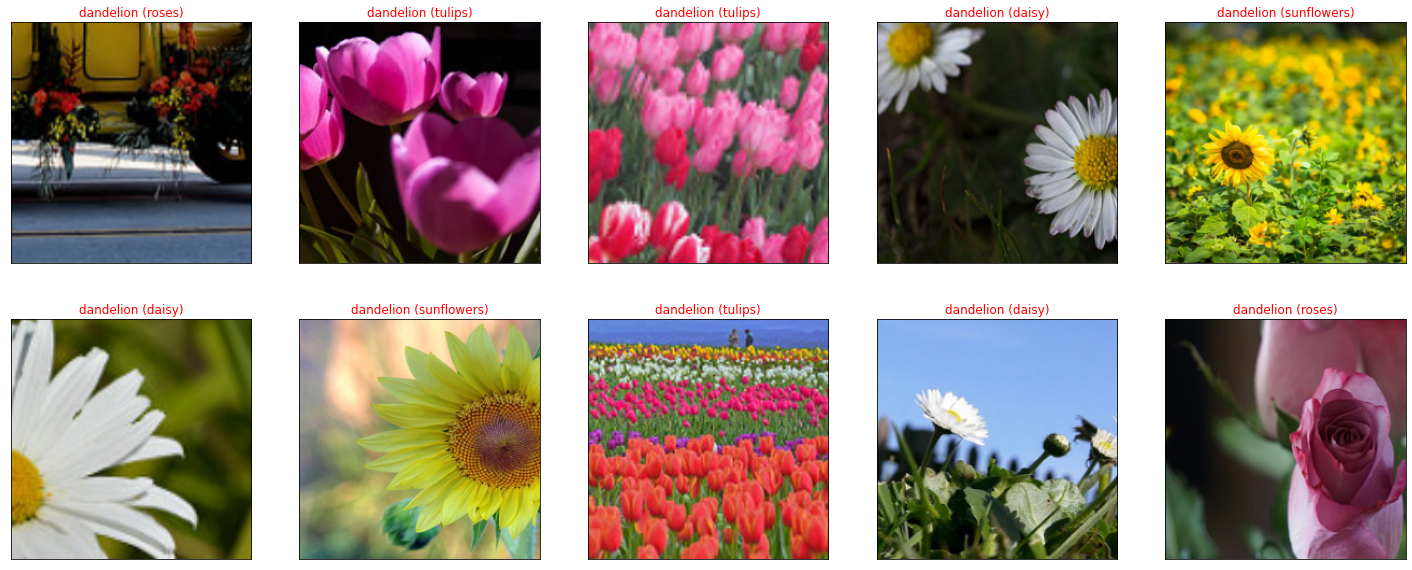

In [ ]:
cfg = {
    'model_name': 'vgg16_naive',
    'n_epochs' : 5,
    'learning_rate': 0.001,
}

# Define Model
vgg16_naive = models.vgg16(pretrained=False)
for param in vgg16_naive.features.parameters():
    param.requires_grad = False
    
vgg16_naive.classifier[6] = nn.Linear(vgg16_naive.classifier[6].in_features, len(classes))
if train_on_gpu:
    vgg16_naive.cuda()

# Train
optimizer = optim.SGD(vgg16_naive.classifier.parameters(), lr=cfg['learning_rate'])
loss_list_4 = train_model(vgg16_naive, cfg)
loss_dict[cfg['model_name']] = loss_list_4

# Evaluate
test_model(vgg16_naive)
plot_loss(loss_dict[cfg['model_name']], title=cfg['model_name'])
visualize_results(vgg16_naive, 10, 2, [25,10])

## Comparision

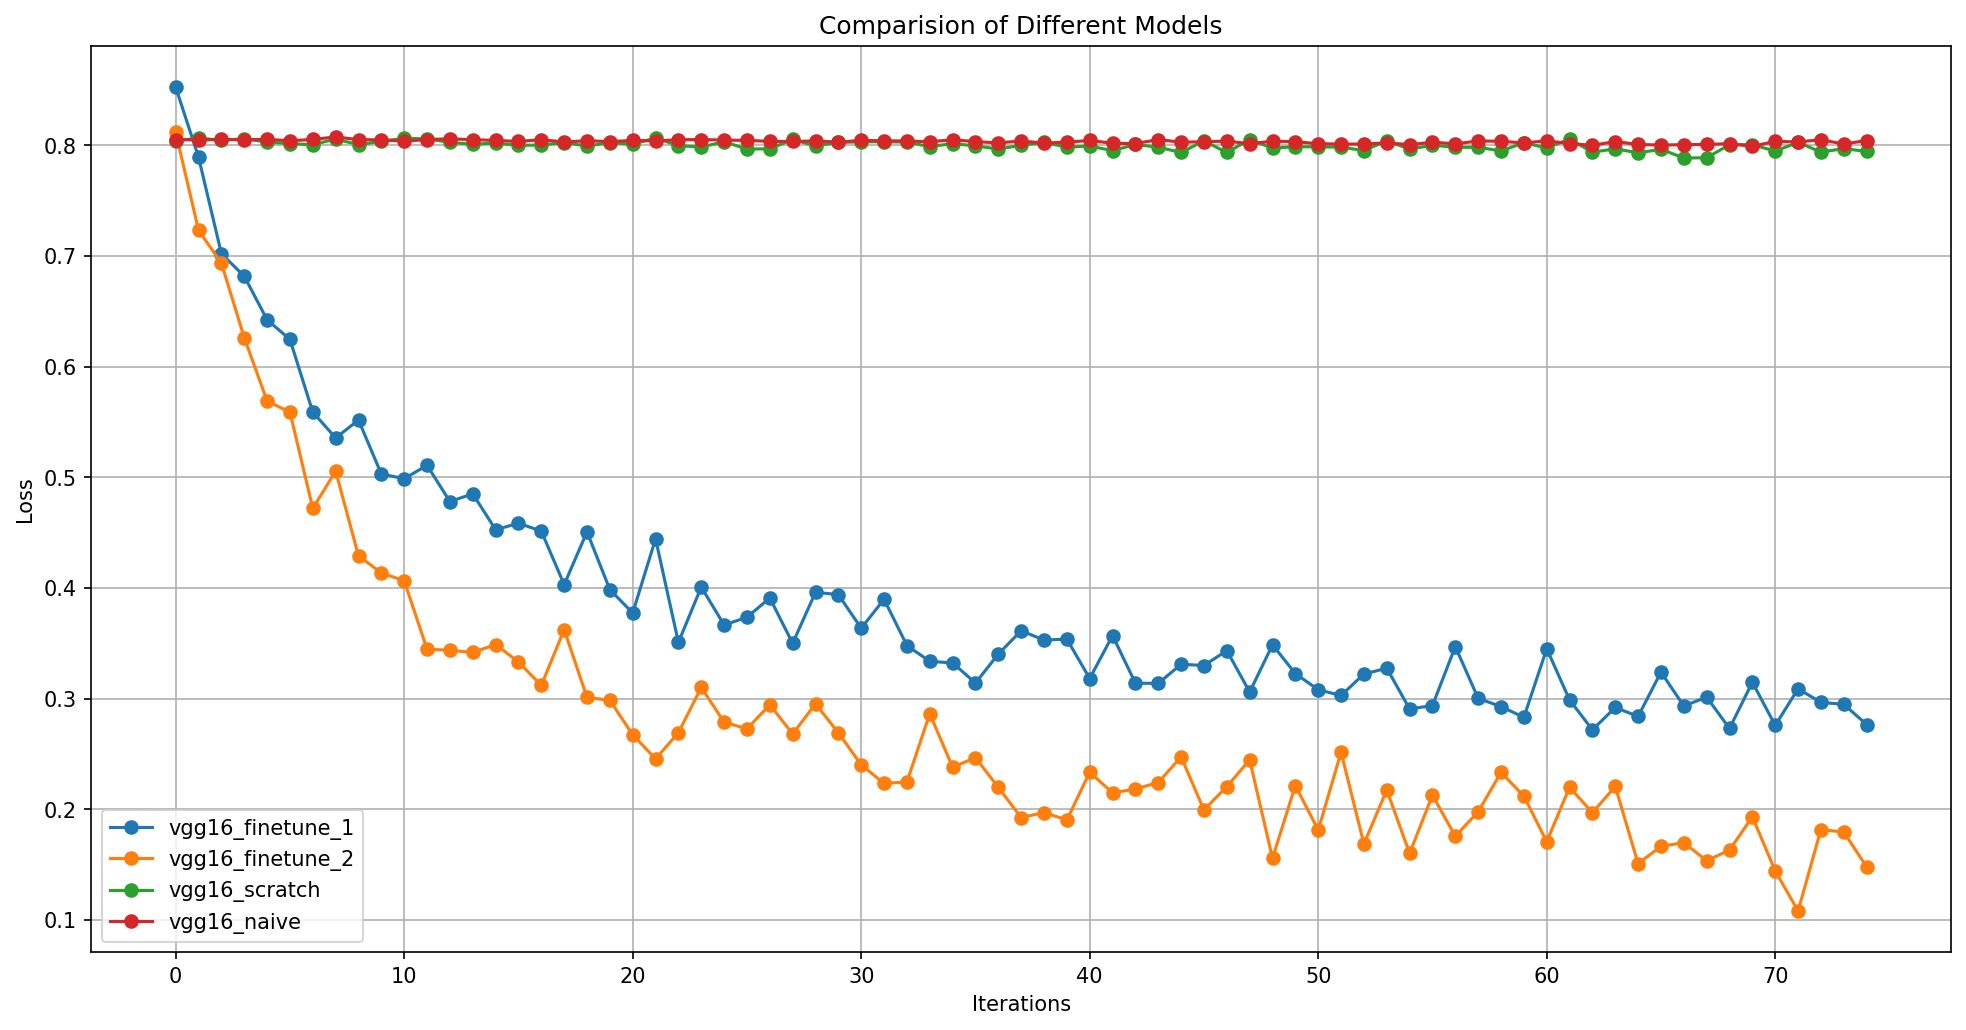

In [ ]:
plt.figure(figsize=[16,8], dpi=150)
for model in loss_dict:
    loss_list = loss_dict[model]
    plt.plot(loss_list, 'o-', label=model)
plt.title('Comparision of Different Models')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.grid()
plt.legend()
plt.show()